<img src="./pictures/logo-insa.jpg" style="float:right; max-width: 120px; display: inline" alt="INSA" /></a>

# Introduction to drone trajectory optimization with FMU models


We want to define here the trajectory which minimize the energy for a given displacement in a given time.
We will use the simulations of Modelica model define as below:
![Drone model](dronespeed.png)

2 different models will be used:
- the first one will have rotational speed as input and inertia torque will be not taken into account
- the second one will have propeller torque as input and inertia torque will be taken into account

The output of the integrator (energy) as to be minimized and the displacement higher than a given value.

The different steps are:
- the FMU model is generated with OpenModelica
- the FMU is used in python with the [pyFMI](https://jmodelica.org/pyfmi/index.html) package.
- the mission profile is  optimized thanks SLQP algorithm



### 1. Speed profile optimization

First we call the FMU with propeller speed as intput.

In [1]:
import os.path as pth
import numpy as np

import scipy
import scipy.optimize
from math import pi
import timeit

from pyfmi import load_fmu

ressources_folder = "../ressources"
model_file_name = "DroneFMU.DroneOptim_Speed.fmu"

file_path = pth.join(ressources_folder, model_file_name)

#Load the FMU
model = load_fmu(file_path) # Model

Then we test the simulation of the model:

In [2]:
#Simulate an FMU
model.reset()
res = model.simulate(final_time=4)           

# Get results
t = res['time'] #Return the result for the variable/parameter/constant y
x = res['droneMassPropeller.x'] #Return the result for the variable/parameter/constant y
n = res['droneMassPropeller.n'] #Return the result for the variable/parameter/constant y
T = res['droneMassPropeller.T'] #Return the result for the variable/parameter/constant y
xp = res['droneMassPropeller.xp'] #Return the result for the variable/parameter/constant y
NRJ = res['NRJ.y'] #Return the result for the variable/parameter/constant y

print(NRJ[-1])
print(T[0])
print(T.max())


Simulation interval    : 0.0 - 4.0 seconds.
Elapsed simulation time: 0.011774299999999016 seconds.
1214.5803447092183
0.04214243003460579
0.056589056503893675


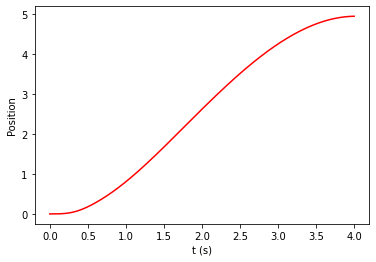

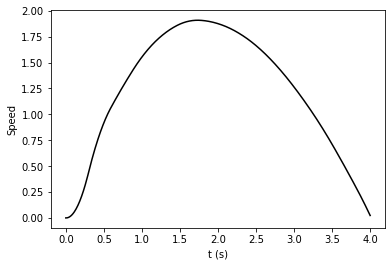

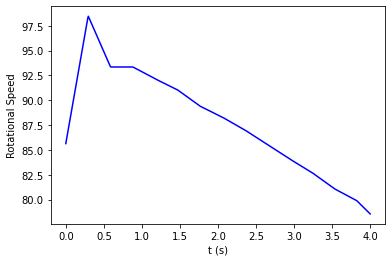

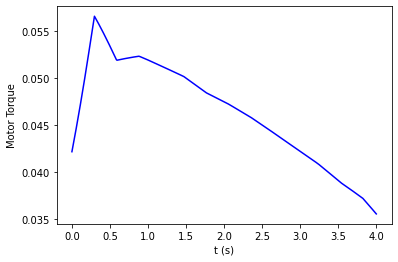

In [3]:
import matplotlib.pyplot as plt
plt.plot(t,x,'r')
plt.ylabel('Position')
plt.xlabel('t (s)')
plt.show()
plt.plot(t, xp,'k')
plt.ylabel('Speed')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,n,'b')
plt.ylabel('Rotational Speed')
plt.xlabel('t (s)')
plt.show()
plt.plot(t,T,'b')
plt.ylabel('Motor Torque')
plt.xlabel('t (s)')
plt.show()


### Call function definition

We define now a function which calculate RMS force and displacement curve depending of a speed profile. 

In [4]:
# -----------------------
# sizing code
# -----------------------
# inputs: 
# - param: optimisation variables vector (reduction ratio, oversizing coefficient)
# - arg: selection of output  
# output: 
# - objective if arg='Obj', problem characteristics if arg='Prt', constraints other else

def SizingCode(param, arg, typeP):
    #  Variables
    #param=np.concatenate((np.array([3.5]), param), axis=0)
    if (param.size % 2) == 0:
        T=5
        j=0
    else:
        T=param[0]
        j=1
        
    nv=np.zeros(16)
    
    for i in range(j,param.size):
        if param.size==4+j:
            nv[4*(i-j)]=param[i]
            nv[4*(i-j)+1]=param[i]
            nv[4*(i-j)+2]=param[i]
            nv[4*(i-j)+3]=param[i]
            
        elif param.size==8+j:
            nv[2*(i-j)]=param[i]
            nv[2*(i-j)+1]=param[i]
            
        elif param.size==16+j:
            nv[i-j]=param[i]
            
        else:
            print("Error")
            
    #print(nv)
     
    # Set FMU parameters
    model.reset()
    model.set('Time', T)
    model.set('n1', nv[0])
    model.set('n2', nv[1])
    model.set('n3', nv[2])
    model.set('n4', nv[3])
    model.set('n5', nv[4])
    model.set('n6', nv[5])
    model.set('n7', nv[6])
    model.set('n8', nv[7])
    model.set('n9', nv[8])
    model.set('n10', nv[9])
    model.set('n11', nv[10])
    model.set('n12', nv[11])
    model.set('n13', nv[12])
    model.set('n14', nv[13])
    model.set('n15', nv[14])
    model.set('n16', nv[15])    
    
    # Simulate
    res = model.simulate(final_time=T)     
    
    # Get results
    t = res['time'] #Return the result for the variable/parameter/constant y
    x = res['droneMassPropeller.x'] #Return the result for the variable/parameter/constant y
    n = res['droneMassPropeller.n'] #Return the result for the variable/parameter/constant y
    T = res['droneMassPropeller.T'] #Return the result for the variable/parameter/constant y
    xp = res['droneMassPropeller.xp'] #Return the result for the variable/parameter/constant y
    xpp = res['droneMassPropeller.der(xp)']
    P= res['droneMassPropeller.P'] 
    Power = res['droneMassPropeller.Power']
    NRJ = res['NRJ.y'] #Return the result for the variable/parameter/constant y
    
    if (typeP=='torque'):
        n = res['droneMassPropeller.n']
        n_hover = res['droneMassPropeller.n_hover']
    
    T_max=T.max()
    T_hov=T[0]
    
# Objective and Constraints sum up
# ---
    if (typeP=='speed'):
        constraints = [(0.1-xp[-1])/.1, (xp[-1]+.1)/.1, (x[-1]-9.9)/10, (10.1-x[-1])/10, 2-T_max/T_hov]
    else:
        constraints = [(0.1-xp[-1])/.1, (xp[-1]+.1)/.1, (x[-1]-9.9)/10, (10.1-x[-1])/10, 
                       (n_hover[-1]*1.01-n[-1])/n_hover[-1], (-n_hover[-1]*0.99+n[-1])/n_hover[-1]]
    
    #print(NRJ[-1])
    
    # Run algorithm slsqp
    if arg == 'Obj':
        return NRJ[-1]/1000 

     # Run algorithm differential evolution
    elif arg == 'ObjP':
        P = 0. # Penalisation nulle
        for C in constraints: 
            if (C < 0.): 
                P = P-1e9*C
        return NRJ[-1] + P # for mass optimisation       


    elif arg=='Prt':
        
        plt.grid()
        plt.plot(t, xpp,'k')
        plt.ylabel('Acceleration (m/s²)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t, xp,'k')
        plt.ylabel('Speed (m/s)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,x,'r')
        plt.ylabel('Position (m)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,n,'b')
        plt.ylabel('Rotational speed (Hz)')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,T,'b')
        plt.ylabel('Torque')
        plt.xlabel('Time (s)')
        plt.show()
        plt.grid()
        plt.plot(t,P,'b',label='Propellers power') 
        plt.plot(t,Power,'r', label='Total power')
        plt.ylabel('Power')
        plt.ylim(bottom=0)
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()
        
        print("* Objective :")
        print("           NRJ = %.3f" % NRJ[-1])
        print("* Optimisation variables:")
        print(param)
        print("* Speed vector:")
        print(nv)
        print("* Constraints :")
        print("           Final speed = %.3f" % (xp[-1]))
        print("           Final position = %.3f " %(x[-1]))
    else:
        return constraints

We test this function with a start set of parameters. These parameters define the profile of the speed curve.

-----------------------------------------------
Initial characteristics before optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.012310300000002883 seconds.


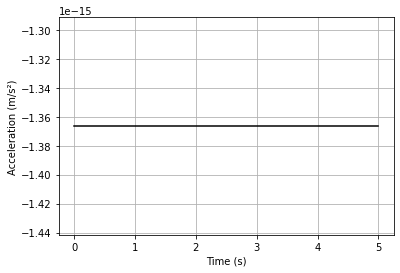

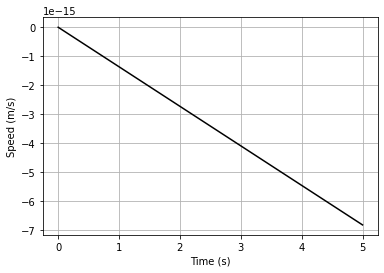

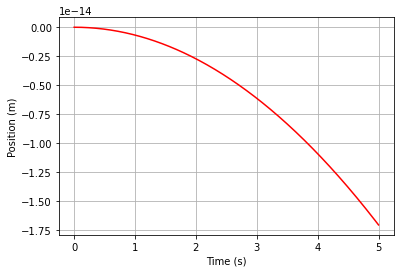

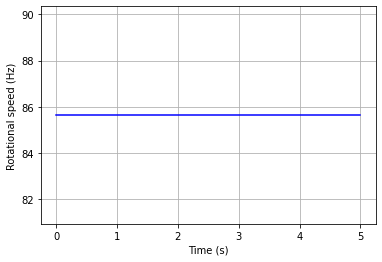

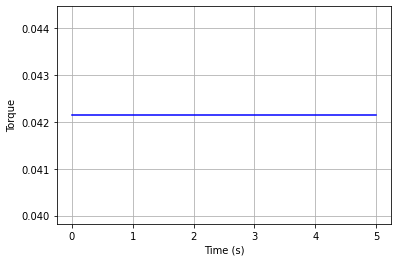

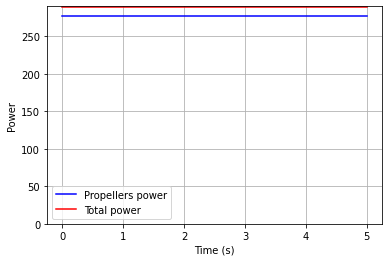

* Objective :
           NRJ = 1445.426
* Optimisation variables:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
* Speed vector:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
* Constraints :
           Final speed = -0.000
           Final position = -0.000 
-----------------------------------------------


In [5]:
import scipy

# Vector of parameters
#parameters = np.array([2.50906559, 1.53543895,1.53543895,1.53543895,1.53543895, 1.13906212,1.13906212,1.13906212,1.13906212, 
#                       1.13906212, 1.13906212,1.13906212, 1.13906212,0.60561077,0.60561077,0.60561077,0.60561077])
#parameters = np.array([3, 1,1,1,1, 1,1,1,1, 
#                       1, 1,1, 1,1,1,1,1])
parameters = np.array([1, 1, 1, 1, 1, 1, 1, 1, 
                       1, 1, 1, 1, 1, 1, 1, 1])

# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")

SizingCode(parameters, 'Prt', typeP='speed')
print("-----------------------------------------------")



### Optimization of the speed curve profile with FMU

We optimize speed mission profile with direct call of FMU function.

In [6]:
min=0.7
max=1.3

# Bounds definition
if parameters.size==4:
    bounds=np.reshape([(min,max)]*4,(4,2))
elif parameters.size==8:
    bounds=np.reshape([(min,max)]*8,(8,2))
elif parameters.size==16:
    bounds=np.reshape([(min,max)]*16,(16,2))
else:
    print("Error")

In [7]:



# Optimization with SLSQP algorithm
contrainte = lambda x: SizingCode(x, 'Const', typeP='speed')
objectif = lambda x: SizingCode(x, 'Obj', typeP='speed')


result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=bounds,
                                   f_ieqcons=contrainte, iter=60, acc=1e-5, iprint = 2, epsilon=.01)




Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.02707849999999823 seconds.
  NIT    FC           OBJFUN            GNORM
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.014378000000000668 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.013034599999997454 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.012135799999999364 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011727900000000346 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011667400000000328 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011588600000003169 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011565099999998552 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011609299999999934 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation t

-----------------------------------------------
Final characteristics after optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.013596499999998457 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.01183860000000081 seconds.


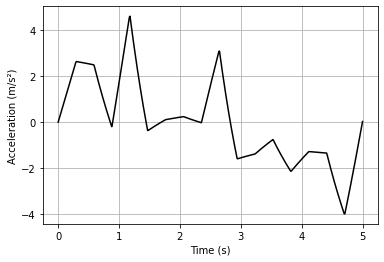

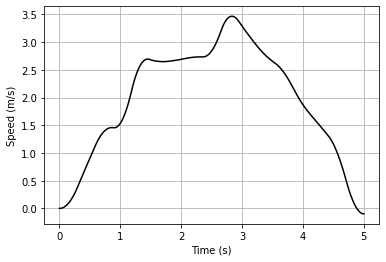

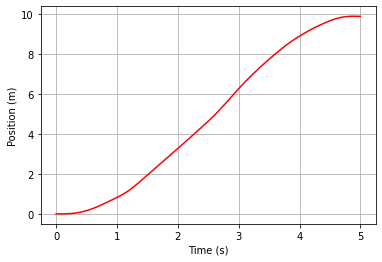

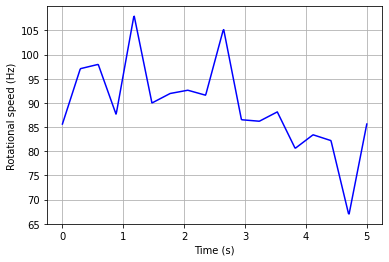

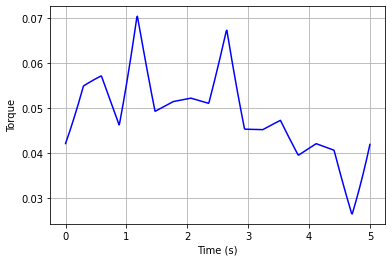

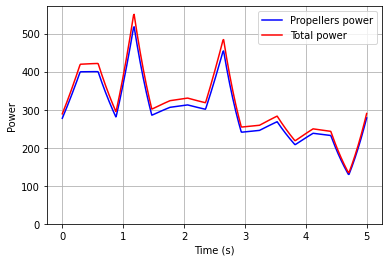

* Objective :
           NRJ = 1568.039
* Optimisation variables:
[1.13374145 1.14417166 1.02304194 1.26303288 1.05084    1.07368973
 1.08176221 1.06962651 1.23024792 1.01040011 1.00678341 1.02949914
 0.94115793 0.97402425 0.95998515 0.7797288 ]
* Speed vector:
[1.13374145 1.14417166 1.02304194 1.26303288 1.05084    1.07368973
 1.08176221 1.06962651 1.23024792 1.01040011 1.00678341 1.02949914
 0.94115793 0.97402425 0.95998515 0.7797288 ]
* Constraints :
           Final speed = -0.100
           Final position = 9.900 


In [8]:

# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

SizingCode(result,'Obj', typeP='speed')
SizingCode(result, 'Prt', typeP='speed')
parameters=result


### 2. Torque profile optimization

First we call the FMU with propeller torque as intput.


In [13]:
ressources_folder = "../ressources"
model_file_name = "DroneFMU.DroneOptim_Torque_old.fmu"

file_path = pth.join(ressources_folder, model_file_name)

#Load the FMU
model = load_fmu(file_path) # Model

parameters = np.array([1, 1, 1, 1, 1, 1, 1, 1, 
                       1, 1, 1, 1, 1, 1, 1, 1])




-----------------------------------------------
Initial characteristics before optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018021500000003243 seconds.


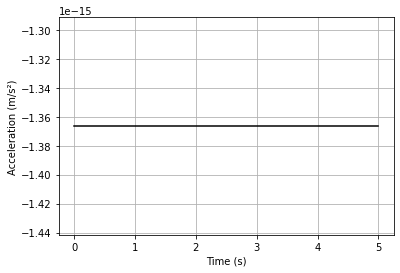

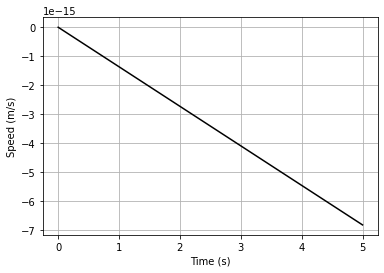

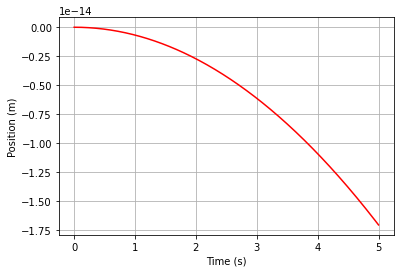

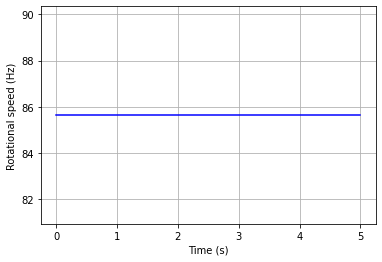

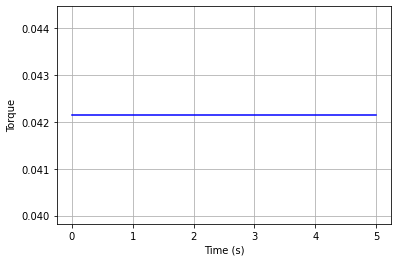

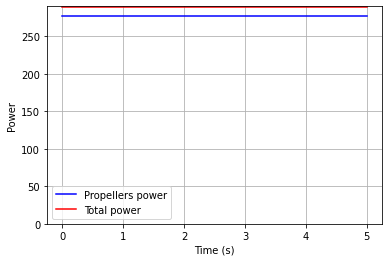

* Objective :
           NRJ = 1445.426
* Optimisation variables:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
* Speed vector:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
* Constraints :
           Final speed = -0.000
           Final position = -0.000 
-----------------------------------------------


In [14]:
# Initial characteristics before optimization 
print("-----------------------------------------------")
print("Initial characteristics before optimization :")

SizingCode(parameters, 'Prt', typeP='torque')
print("-----------------------------------------------")

In [15]:
min=0.1
max=2

# Bounds definition
if parameters.size==4:
    bounds=np.reshape([(min,max)]*4,(4,2))
elif parameters.size==8:
    bounds=np.reshape([(min,max)]*8,(8,2))
elif parameters.size==16:
    bounds=np.reshape([(min,max)]*16,(16,2))
else:
    print("Error")

# Optimization with SLSQP algorithm
contrainte = lambda x: SizingCode(x, 'Const', typeP='torque')
objectif = lambda x: SizingCode(x, 'Obj', typeP='torque')


result = scipy.optimize.fmin_slsqp(func=objectif, x0=parameters, 
                                   bounds=bounds,
                                   f_ieqcons=contrainte, iter=60, acc=1e-5, iprint = 2, epsilon=.01)




Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018157100000010473 seconds.
  NIT    FC           OBJFUN            GNORM
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018711499999994885 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.016128299999991214 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.012190799999999058 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.012300200000012751 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.01164840000001277 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011974399999999719 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011854799999994725 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.011786999999998216 seconds.
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation t

-----------------------------------------------
Final characteristics after optimization :
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.0120835000000028 seconds.
1.5673541149245709
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.014626499999991438 seconds.
[1.9999948668113814, 5.1331886187500064e-06, -8.196490952627756e-09, 0.020000008196490882, 0.019999986092390905, 1.3907609204018338e-08]
Simulation interval    : 0.0 - 5.0 seconds.
Elapsed simulation time: 0.018617399999996564 seconds.


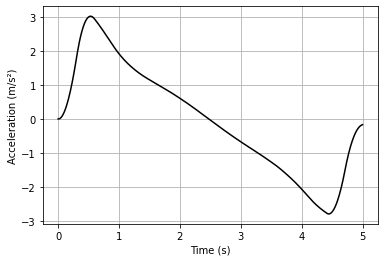

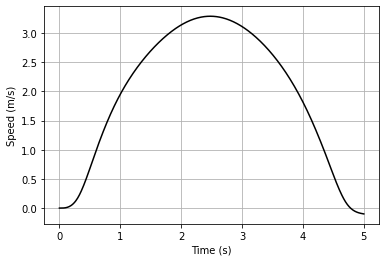

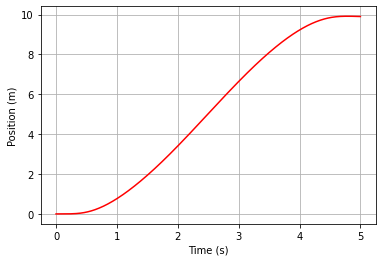

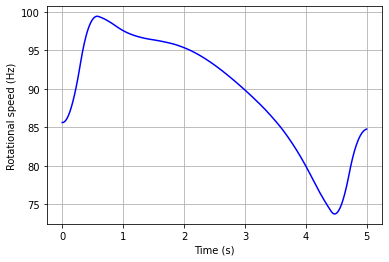

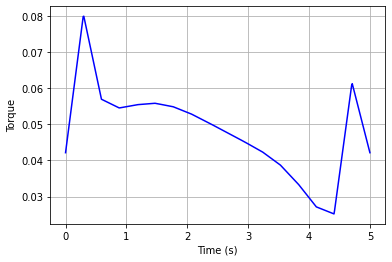

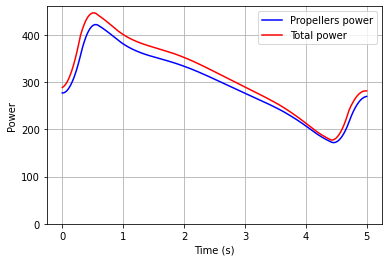

* Objective :
           NRJ = 1567.354
* Optimisation variables:
[1.90727227 1.35144663 1.29377916 1.31525855 1.32457736 1.30234773
 1.2556609  1.1959429  1.13298998 1.07098481 1.00492218 0.91870392
 0.79382637 0.64448639 0.59766413 1.45960889]
* Speed vector:
[1.90727227 1.35144663 1.29377916 1.31525855 1.32457736 1.30234773
 1.2556609  1.1959429  1.13298998 1.07098481 1.00492218 0.91870392
 0.79382637 0.64448639 0.59766413 1.45960889]
* Constraints :
           Final speed = -0.100
           Final position = 9.900 


In [16]:
# Final characteristics after optimization 
print("-----------------------------------------------")
print("Final characteristics after optimization :")

print(SizingCode(result,'Obj', typeP='torque'))
print(SizingCode(result,'Cst', typeP='torque'))
SizingCode(result, 'Prt', typeP='torque')
parameters=result
